In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import optimizers, regularizers, models, layers, callbacks
from sklearn.utils import class_weight

from prosenet import ProSeNet, PrototypeProjection, datasets, ops

In [2]:
# Dataset parameters

num_classes = 3
sequence_length = 200
num_features = 1

In [3]:
# Set any non-default args
new_rnn_args = {
    'layers' : [8],
    'layer_args' : {
        'dropout' : 0.1,
        'activity_regularizer' : regularizers.l2(0.1)    # Note: not in paper
    }
}

new_proto_args = {
    'dmin' : 2.0,
    'Ld' : 0.1, #0.1,
    'Lc' : 0.01,
    'Le' : 0.1
}

pnet = ProSeNet(input_shape=(sequence_length, num_features), 
                nclasses=num_classes, 
                k=8, 
                rnn_args=new_rnn_args,
                prototypes_args=new_proto_args,
                L1=0.1)

pnet.build( (None, sequence_length, num_features) )

pnet.summary()

Model: "pro_se_net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 16)                640       
_________________________________________________________________
prototypes (Prototypes)      multiple                  128       
_________________________________________________________________
classifier (Dense)           multiple                  24        
Total params: 792
Trainable params: 792
Non-trainable params: 0
_________________________________________________________________


In [4]:
data = datasets.SyntheticSignalsDataset(examples_per_class=500)
data.load_data()

data.X_train.shape, data.y_train.shape, data.X_test.shape, data.y_test.shape

((1200, 200, 1), (1200, 3), (300, 200, 1), (300, 3))

In [5]:
train_gen = datasets.DataGenerator(data.X_train, data.y_train, batch_size=128)

test_gen = datasets.DataGenerator(data.X_test, data.y_test, batch_size=128)

class_weights = 1 - (np.bincount(np.argmax(data.y_train, 1)) / data.y_train.shape[0])

# Setting class 0 to 0.001, need to just get it to stop overfitting that class
#class_weights[0] = 0.0
class_weights

array([0.65416667, 0.66583333, 0.68      ])

# First train just the `encoder`

In [6]:
x_encoded = pnet.encoder.output

pred = layers.Dense(3, activation='softmax')(x_encoded)

encoder_classifier = models.Model(inputs=pnet.encoder.input, outputs=pred)

encoder_classifier.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200, 1)]          0         
_________________________________________________________________
bidirectional (Bidirectional (None, 16)                640       
_________________________________________________________________
dense (Dense)                (None, 3)                 51        
Total params: 691
Trainable params: 691
Non-trainable params: 0
_________________________________________________________________


In [7]:
rms = optimizers.RMSprop()

encoder_classifier.trainable = True

encoder_classifier.compile(optimizer=rms, loss='categorical_crossentropy', metrics=['accuracy'])

encoder_classifier.fit_generator(train_gen, 
                   validation_data=test_gen, 
                   epochs=25,
                   shuffle=False)

Epoch 1/25
10/10 [==============================] - 2s 210ms/step - loss: 1.0697 - accuracy: 0.5683 - val_loss: 1.0516 - val_accuracy: 0.5433
Epoch 2/25
10/10 [==============================] - 1s 51ms/step - loss: 1.0327 - accuracy: 0.6492 - val_loss: 1.0252 - val_accuracy: 0.6167
Epoch 3/25
10/10 [==============================] - 1s 54ms/step - loss: 1.0068 - accuracy: 0.6950 - val_loss: 1.0037 - val_accuracy: 0.6367
Epoch 4/25
10/10 [==============================] - 1s 54ms/step - loss: 0.9827 - accuracy: 0.6950 - val_loss: 0.9808 - val_accuracy: 0.6433
Epoch 5/25
10/10 [==============================] - 0s 48ms/step - loss: 0.9560 - accuracy: 0.7233 - val_loss: 0.9552 - val_accuracy: 0.6567
Epoch 6/25
10/10 [==============================] - 0s 46ms/step - loss: 0.9289 - accuracy: 0.7283 - val_loss: 0.9295 - val_accuracy: 0.6867
Epoch 7/25
10/10 [==============================] - 0s 48ms/step - loss: 0.9013 - accuracy: 0.7492 - val_loss: 0.9014 - val_accuracy: 0.7233
Epoch 8/25
1

# Now freeze the `encoder`

In [8]:
pnet.encoder.trainable = False

In [33]:
# Define come `Callback`s

init_lr = 0.01 # 1.0

def lr_schedule(epoch):
    if epoch <= 10:
        return init_lr
    else:
        return init_lr * 0.85**(epoch - 10)
    
lr_schedule = callbacks.LearningRateScheduler(lr_schedule)

early_stopping = callbacks.EarlyStopping(patience=3)

projection = PrototypeProjection(train_gen, freq=4)

In [34]:
sgd = optimizers.SGD(learning_rate=init_lr, clipnorm=5.0)

pnet.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

pnet.fit_generator(train_gen, 
                   validation_data=test_gen, 
                   epochs=25,
                   callbacks=[early_stopping, lr_schedule, projection],
                   shuffle=False)

Epoch 1/25
 9/10 [==========================>...] - ETA: 0s - loss: 5.0977 - accuracy: 0.7543
Computing prototype projection...
... assigned new prototypes from projections.
10/10 [==============================] - 1s 68ms/step - loss: 4.9164 - accuracy: 0.7492 - val_loss: 1.2579 - val_accuracy: 0.7433
Epoch 2/25
10/10 [==============================] - 1s 53ms/step - loss: 4.9889 - accuracy: 0.7500 - val_loss: 1.2579 - val_accuracy: 0.7333
Epoch 3/25
10/10 [==============================] - 1s 52ms/step - loss: 4.8808 - accuracy: 0.7675 - val_loss: 1.2575 - val_accuracy: 0.7667
Epoch 4/25
10/10 [==============================] - 1s 50ms/step - loss: 4.9462 - accuracy: 0.7850 - val_loss: 1.2575 - val_accuracy: 0.7700
Epoch 5/25
 8/10 [=======================>......] - ETA: 0s - loss: 5.1191 - accuracy: 0.7881
Computing prototype projection...
... assigned new prototypes from projections.
10/10 [==============================] - 1s 73ms/step - loss: 4.9489 - accuracy: 0.7883 - val_loss:

# Diagnostics

In [35]:
# Encoding layer(s) output
pnet.encoder.predict(data.X_train[np.newaxis, 0], batch_size=1)

array([[-0.24914569, -0.34737614, -0.24518126,  0.06854209, -0.24509007,
         0.00762364,  0.17421354, -0.31089938, -0.05756561,  0.12854348,
        -0.37448364, -0.33903867,  0.16461122,  0.2979516 ,  0.33566877,
         0.3850568 ]], dtype=float32)

-0.6946183 0.68691134


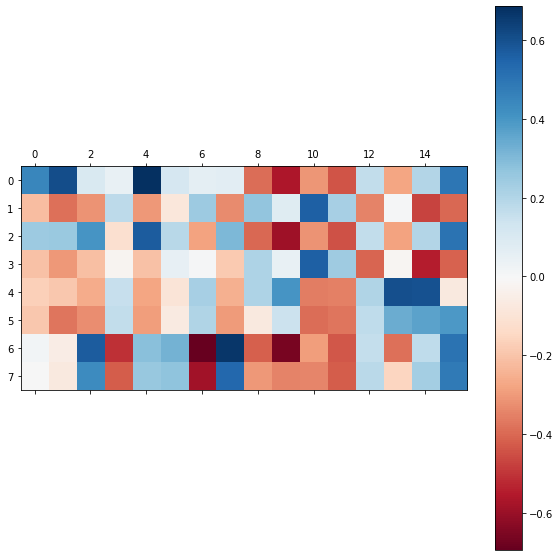

In [36]:
# Prototype layer weights
protos = np.squeeze(pnet.prototypes_layer.weights[0].numpy())
print(protos.min(), protos.max())

fig, ax = plt.subplots(figsize=(10,10))
cax = ax.matshow(protos, cmap=plt.cm.RdBu)
fig.colorbar(cax, ax=ax)

0.0 0.43311659


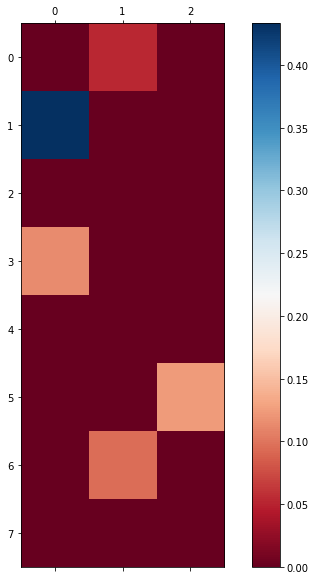

In [37]:
pred_weights = np.squeeze(pnet.classifier.weights[0].numpy())
print(pred_weights.min(), pred_weights.max())

fig, ax = plt.subplots(figsize=(10,10))
cax = ax.matshow(pred_weights, cmap=plt.cm.RdBu)
fig.colorbar(cax)

In [38]:
pnet.predict(data.X_train[:3,:], batch_size=1)

array([[0.340934  , 0.31557238, 0.3434936 ],
       [0.33367836, 0.34120822, 0.32511348],
       [0.43659985, 0.2799623 , 0.28343776]], dtype=float32)

In [39]:
data.y_train[:3]

array([[0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.]], dtype=float32)

In [16]:
pnet.predict(data.X_test[-3:,:], batch_size=1)

array([[0.3664832 , 0.29701304, 0.33650377],
       [0.36368415, 0.2655087 , 0.37080714],
       [0.38782075, 0.27842987, 0.33374938]], dtype=float32)

In [17]:
data.y_test[-3:]

array([[0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.]], dtype=float32)

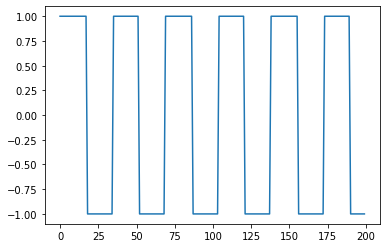

In [18]:
plt.plot(np.arange(200), data.X_train[-2])

In [40]:
pnet.classifier.weights[0]

<tf.Variable 'classifier/kernel:0' shape=(8, 3) dtype=float32, numpy=
array([[0.00000000e+00, 5.33084050e-02, 0.00000000e+00],
       [4.33116585e-01, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 1.04193896e-04, 0.00000000e+00],
       [1.14162803e-01, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 1.93002605e-04],
       [0.00000000e+00, 0.00000000e+00, 1.24765858e-01],
       [0.00000000e+00, 9.51026753e-02, 0.00000000e+00],
       [0.00000000e+00, 8.85083791e-05, 0.00000000e+00]], dtype=float32)>

In [20]:
encoder_classifier.layers[-1].weights

[<tf.Variable 'dense/kernel:0' shape=(16, 3) dtype=float32, numpy=
 array([[-0.5213511 , -0.05899869, -0.249026  ],
        [-0.33939865,  0.70954776, -0.3884023 ],
        [-0.6738875 , -0.03435083, -0.4629696 ],
        [-0.25881425, -0.28660363,  0.0663461 ],
        [-0.5577714 ,  0.65599936, -0.5657713 ],
        [ 0.33426517,  0.57936794, -0.51241493],
        [ 0.7576804 , -0.45098963, -0.17132345],
        [-0.46536216,  0.6107482 , -0.21731524],
        [ 0.23351939, -0.31686026,  0.04567785],
        [ 0.31412268, -0.14741938,  0.7284041 ],
        [ 0.58505046, -0.7802096 , -0.79667944],
        [ 0.30450213, -0.42327034, -0.46204495],
        [-0.21081522,  0.10678521,  0.5650489 ],
        [-0.60199594, -0.3655303 ,  0.826468  ],
        [-0.6344607 , -0.3321292 ,  0.6599879 ],
        [-0.66695017,  0.40730286,  0.06610867]], dtype=float32)>,
 <tf.Variable 'dense/bias:0' shape=(3,) dtype=float32, numpy=array([ 0.01764691,  0.00150107, -0.02701428], dtype=float32)>]

In [21]:
pnet.prototypes_layer._diversity_term()

<tf.Tensor: id=271661, shape=(), dtype=float32, numpy=10.618939>

In [22]:
pnet.encoder.predict(data.X_train[np.newaxis, 0], batch_size=1)

array([[-0.24914569, -0.34737614, -0.24518126,  0.06854209, -0.24509007,
         0.00762364,  0.17421354, -0.31089938, -0.05756561,  0.12854348,
        -0.37448364, -0.33903867,  0.16461122,  0.2979516 ,  0.33566877,
         0.3850568 ]], dtype=float32)

In [23]:
similarities = pnet.similarity_vector(data.X_train[1:3]).numpy()


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



In [24]:
data.y_train[1:3]

array([[0., 1., 0.],
       [1., 0., 0.]], dtype=float32)

In [25]:
similarities

array([[0.4529837 , 0.08046876, 0.8724249 , 0.08961628, 0.11949158,
        0.1541241 , 0.5187751 , 0.61605746],
       [0.08793184, 0.8813068 , 0.08269343, 0.6346254 , 0.17530733,
        0.1841182 , 0.08412625, 0.10743003]], dtype=float32)

In [26]:
np.argmax(pnet.classifier.weights[0].numpy(), -1)

array([0, 2, 1, 1, 2, 0, 2, 0])